# Importing Libraries

In [1]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
#import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

# Function to Render Video

In [2]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

# Making the Environment

In [3]:
env = gym.make("CartPole-v1")

500


# Initializing the Hyperparameters

Purpose of each hyperparameter:
1. **LEARNING_RATE** = Determines the step size at which the agent updates its Q-values during the learning process. A smaller learning rate can lead to slower learning but may converge a better solution, while a larger learning rate can lead to faster learning but may not converge to an optimal solution. Based on our testing, we found 0.2 is the optimal value

2. **DISCOUNT** = The determines the discount factor for future rewards in the Q-learning algorithm. A higher discount factor values futures rewards more than immediate rewards. Based on our testing, we found 1 is the optimal value.

3. **EPSIODES** = This determines the number of episodes that the agent will play duirng the learning process. 

4. **Observation** = Determines the size of the observation space for the agent. In this case, it is a list of 4 numbers representing the screen's dimensions and the angle and position of the pole.

5. **np_array_win_size** = determines the size of the window used to discretize the observation space

6. **epsilon** = Determines the exploration rate of the agent during training. Initially epsilon starts at 1, meaning the agent always chooses a random action. The more the agent trains the epsilon is decreased to help it make better decisions

7. **epsilon_min** = determines the minimum value of epsilon, ensuring that the agent continues to explore even after many epsidoes of training while selecting the best action 95% of the time

7. **epsilon_decay** = determines the constant rate at which epsilon decreases over time, allowing the agent to explore less as it becomes more familiar with the environment. 


8. **rewardArr** = list to store the reward obtained by the agent at each episode during training. 

In [4]:
#Defining Hypermeters

LEARNING_RATE = 0.2
DISCOUNT = 1 
EPISODES = 50000


# Define observation and window size
Observation = [40, 40, 50, 50]
np_array_win_size = np.array([0.25, 0.25, 0.05, 0.5])


epsilon = 1
epsilon_min = 0.05
epsilon_decay = (epsilon-epsilon_min)/12500


obs = env.reset()

rewardArr = []


# Creating the Q-Table

Importance of Q-Table:
It is used in Q-learning algorithm to store the estimated Q-values for each state-action pair in the environment. The Q-value represents the expected cumulative reward for taking a particular action from a particular state.

In [5]:
q_table = np.zeros((Observation + [env.action_space.n]))
q_table.shape

(40, 40, 50, 50, 2)

The above code initializes a Q-table as NumPy array of zeroes. The shape of the array is determined by the size of the observation space plus the number of actions available in the env (specified by env.action_space)

The Q-table is initialized with all zeroes to represent that the agent has no prior knowledge about the env and its q-values. During the learning process, the agent updates the Q-values based on the rewards obtained and the transitions between states, ultimately leading to a better performance. 

# Getting a Discrete State

The observation contains 4 continuous variables corresponding the cart position & velocity, pole angle & velocity

Because the environment state is continuous, we will need to discretize its values 

In [6]:
#defining the discrete state
def get_discrete_state(state):
    
    discrete_state = state/np_array_win_size+ np.array([15,10,1,10])

    return tuple(discrete_state.astype(int)) 


(31, 2, 9, 11)


# Task 1 - Training the Agent

Here, we will be developing our RL Agent. After defining the hyper parameters, Q-table, and discrete state before, we run the following code to train our agent.

#### Note: In our environment, the episode does not automatically end when it hits 500 step. During training, we can expect mean values to be greater than 500.  We will manually truncate the episode during testing subsequently

In [7]:
#Looping over the number of episodes
def agent(env, EPISODES, LEARNING_RATE, DISCOUNT, epsilon, epsilon_decay,q_table):
    total_reward = 0
    prev_mean =0
    for episode in range(EPISODES):

        #reset the environment and get the initial state
        discrete_state = get_discrete_state(env.reset()[0])
        done = False
        episode_reward = 0
        episode_length = 0
        
       
        # update every 2000 episodes
        if episode % 2000 == 0:
            print("Episode: " + str(episode))

        #Loop until the episodes are complete
        while not done:

            # Determine the action to take using epsilon-greedy policy
            if np.random.random() > epsilon:
                action = np.argmax(q_table[discrete_state])
            else:
                action = np.random.randint(0, env.action_space.n)

            #Take the chosen action and observe the new state and reward
            new_env = env.step(action)
            new_state = new_env[0]
            reward = new_env[1]
            done = new_env[2]
            episode_reward += reward
            episode_length += 1
            

            #Discretize the new state and find the maximum Q-value for the new state
            new_discrete_state = get_discrete_state(new_state)
            max_future_q = np.max(q_table[new_discrete_state])
            current_q = q_table[discrete_state + (action,)]
            

            # Shaping the reward based on whether the epsiode is complete and the 
            #length of the episode
            #Encouraging agent to try different actions and explore the environment
            if done:
                if episode_length >= 195:
                    reward = 1 #agent receives a reward of +1 if it has survived >195 steps
                else:
                    reward = -1 #otherwise, receives reward of -1
            else:
                reward = 0.1

            #Updating the Q-table using the Q-learning update rule
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            q_table[discrete_state + (action,)] = new_q

            #Update the current state to the new state
            discrete_state = new_discrete_state

        #Tracking the total episode reward and
        #reward for each episode
        total_reward += episode_reward
        rewardArr.append(episode_reward)

        #Update the exploration rate epsilon
        #if episode reward is less than the mean of the past 1000 values then we will let it explore more and not decrease the epsilon
        if epsilon > 0.05 and episode_reward > prev_mean:
            epsilon -= epsilon_decay

        #Print progress every 1000 episodes
        if episode % 1000 == 0:
            print("Epsilon: " + str(epsilon))
            mean_reward = total_reward / 1000
            print("Mean Reward: " + str(mean_reward))

            #Update the previous mean and reset the total reward
            prev_mean = mean_reward
            total_reward = 0
            
    #closing the environment and returning the trained q_table and rewardArr
    env.close()
    return q_table, rewardArr


#Running the training agent based on the initial parameters
q_table, rewards = agent(env, EPISODES, LEARNING_RATE, DISCOUNT, epsilon, epsilon_decay, q_table)

Episode: 0
Epsilon: 0.999924
Mean Reward: 0.015
Epsilon: 0.923924000000035
Mean Reward: 22.737
Episode: 2000
Epsilon: 0.8872920000000519
Mean Reward: 26.695
Epsilon: 0.8542320000000672
Mean Reward: 29.166
Episode: 4000
Epsilon: 0.8252760000000805
Mean Reward: 29.669
Epsilon: 0.7918360000000959
Mean Reward: 32.373
Episode: 6000
Epsilon: 0.756952000000112
Mean Reward: 35.86
Epsilon: 0.720092000000129
Mean Reward: 39.018
Episode: 8000
Epsilon: 0.685284000000145
Mean Reward: 42.034
Epsilon: 0.6510840000001608
Mean Reward: 45.005
Episode: 10000
Epsilon: 0.6139960000001778
Mean Reward: 51.275
Epsilon: 0.5775160000001947
Mean Reward: 55.327
Episode: 12000
Epsilon: 0.5400480000002119
Mean Reward: 59.604
Epsilon: 0.49862800000022994
Mean Reward: 68.049
Episode: 14000
Epsilon: 0.46040000000021963
Mean Reward: 75.277
Epsilon: 0.42042400000020885
Mean Reward: 81.161
Episode: 16000
Epsilon: 0.37999200000019795
Mean Reward: 88.694
Epsilon: 0.33994000000018715
Mean Reward: 94.437
Episode: 18000
Epsil

# Task 1 - Sampling a Random State

Here, we sample a random state from the cart pole environment, inputting to the agent, and outputting a chosen action. 

In [9]:
#Initializing the CartPole-v1 env
env = gym.make("CartPole-v1")

#Resetting the env and obtaining the initial observation
observation = env.reset()

#Printing out the first element of the observation array
print("Observation:" , observation[0] )

#Converting the continuous observation to a discrete state
discrete_state = get_discrete_state(observation[0])

#Using the Q-table to choose the best action for the current state
action = np.argmax(q_table[discrete_state])

#Printing out the chosen action
print("Chosen Action:", action)


Observation: [ 2.2139385e-02  2.6568612e-02  7.1117110e-03 -4.2741223e-05]
Chosen Action: 0


# Task 2 - Effectiveness of the RL Agent

We will be plotting a graph of the cumulative reward of our agent over 100 episodes.
We will then be calculating the average of the rewardArr and checking whether it is >195 to ensure that our agent is good enough and satisfies the condition. 

#### Note: We will manually truncate the agent if episode_reward>500

In [10]:
#Define empty list to store the total rewards obtained in each episode
final_rewardArr = []

#Running 100 episodes
for episodes in range (100):
    
    #Reset the env and obtain the initial observation
    discrete_state = get_discrete_state(env.reset()[0])
    done = False
    episode_reward = 0
    
    #Run episodes until done flag is set to True
    while not done:

        #Using Q-table to always choose the best action for current state
        action = np.argmax(q_table[discrete_state])

        #take chosen action in env and obtain new state, reward, and done flag
        new_env = env.step(action)
        new_state = new_env[0]
        reward = new_env[1]
        done = new_env[2]

        #Add reward for the current step to the episode reward variable
        episode_reward += reward

        #Ending the episode also if it reached 500
        if episode_reward >500:
            done = True
            
        #Convert new state to its discrete equivalent and update discrete_state
        new_discrete_state = get_discrete_state(new_state)
        discrete_state = new_discrete_state
        
        #if episode is complete, reset env and obtain initial observation and discrete state
        if done:
            observation = env.reset()
            discrete_state = get_discrete_state(observation[0])
            
    #Append the episode reward to the final_rewardArr list
    final_rewardArr.append(episode_reward)
env.close()

# Plotting Graph 

Average cumulative reward:299.61
Is my agent good enough? True


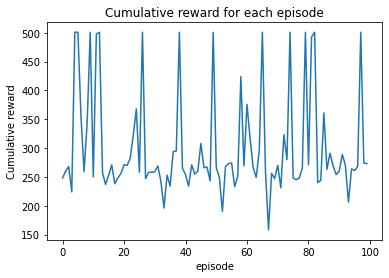

In [11]:
plt.plot(final_rewardArr)


print("Average cumulative reward:" + str(np.mean(final_rewardArr)))
print("Is my agent good enough? " + str(np.mean(final_rewardArr) > 195))

plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')

plt.show()

As seen above, it is evident that our RL agent is good enough as our average cumulative reward is GREATER THAN 195. 

**Note: We have run the above codes 5 times and have, on average, gotten an average cumulative reward between 250-300. However, in earlier trials, there were times where the average cumulative reward is below those values. This may be due to the randomness involved in the code.**

# Task 3 - Rendering 1 Episode

Here, we would be testing our trained agent by rendering 1 episode to see whether the pole is able to balance on the cart for a period of time. 

In [13]:
#Set the initial value of episode_reward to 0
episode_reward = 0

#Creating instance of RecordVideo 
env = RecordVideo(gym.make("CartPole-v1", render_mode="human"),"./video")

#Reset env and obtain initial observation and discrete state
observation = env.reset()
discrete_state = get_discrete_state(observation[0])


done = False
while not done:
    env.render()
    
    #Determining action to take based on q_table values and select action with highest value
    action = np.argmax(q_table[discrete_state])
    
    #take chosen action in env and obtain new state, reward, and done flag
    new_env = env.step(action)
    new_state = new_env[0]
    reward = new_env[1]
    done = new_env[2]
    
    #Add reward for the current step to the episode reward variable
    episode_reward += reward
    
    #Convert new state to its discrete equivalent and update discrete_state
    new_discrete_state = get_discrete_state(new_state)
    discrete_state = new_discrete_state
    
    #if episode is complete, reset env and obtain initial observation and discrete state
    if done:
        observation = env.reset()
        discrete_state = get_discrete_state(observation[0])

env.close()
show_video()
print(episode_reward)

Could not find video
279.0


# Conclusion


After training our agent using the **Q-learning algorithm** with carefully selected hyperparameters such as a **learning rate of 0.2**, a **discount factor of 1** and running the training process for **50,000 episodes**, we were able to achieve an **average cumulative reward greater than 195 over the course of 100 episodes**. This indicates that our agent has learned an effective strategy for balancing the cartpole.

Furthermore, we were able to successfully render one episode of our trained agent, demonstrating that our model can perform well in a real-world scenario. By using a Q-table and carefully selecting hyperparameters, we were able to create an effective reinforcement learning model that can solve the cartpole problem.